In [1]:
%cd ../..

/home/matheus/Desktop/Itens/Projetos/crawlers/jornais-universidades-crawler


# Nulls

In [2]:
import csv
import json
import os

def validate_json_fields(json_path):
    # Extract dataset name from the path
    dataset_name = json_path.split('/')[2]

    # Check if the file exists
    if not os.path.exists(json_path):
        print(f"The JSON file was not found: {json_path}")
        return {"Dataset": dataset_name}

    # Read the JSON file
    with open(json_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Ensure it's a list of instances
    if not isinstance(data, list):
        print(f"The JSON does not contain a list: {json_path}")
        return {"Dataset": dataset_name}

    # Fields to be checked
    fields_to_check = ["Title", "Description", "Text", "News Category", "Publication Date", "Updated Date", "Number Access"]
    null_counts = {field: 0 for field in fields_to_check}
    null_images = 0
    null_authors = 0
    null_links = 0
    null_additional = 0
    total_images = 0

    # Validate each instance
    for instance in data:
        if instance.get("Authors", []) == []:
            null_authors += 1

        if instance.get("Related Links", []) == []:
            null_links += 1

        if instance.get("Additional Content", []) == []:
            null_additional += 1


        for field in fields_to_check:
            value = instance.get(field, None)
            if value is None or (isinstance(value, str) and value.strip() == ""):
                null_counts[field] += 1

        images = instance.get("Images", [])
        for image in images:
            caption = image.get("Caption", None)
            if caption is None or caption.strip() == "":
                null_images += 1
            total_images += 1

    total_instances = len(data)
    null_percentages = {field: count / total_instances for field, count in null_counts.items()}
    null_percentages['Images Caption'] = null_images / total_images if total_images > 0 else 0
    null_percentages['Links'] = null_links / total_instances
    null_percentages['Additional Content'] = null_additional / total_instances
    null_percentages['Authors'] = null_authors / total_instances
    null_percentages['Dataset'] = dataset_name

    return null_percentages

def save_to_csv(output_path, datasets):
    # Process all datasets
    results = []
    for dataset in datasets:
        percentages = validate_json_fields(dataset)
        results.append(percentages)

    # Get all unique keys for the CSV header
    keys = set(key for result in results for key in result.keys())
    header = ["Dataset"] + sorted(k for k in keys if k != "Dataset")

    # Write results to CSV
    with open(output_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=header)
        writer.writeheader()
        writer.writerows(results)


In [3]:
import pandas as pd

# Paths to datasets
datasets = [
    "data/postprocessing/UFRB/data.json", 
    "data/postprocessing/UFRJ/data.json", 
    "data/postprocessing/UNESP/data.json", 
    "data/postprocessing/UNICAMP/data.json",
    "data/postprocessing/USP/data.json"
]

# Output CSV path
output_csv = "null_percentages.csv"

# Save results to CSV
save_to_csv(output_csv, datasets)

df = pd.read_csv(output_csv)
df

The JSON file was not found: data/postprocessing/USP/data.json


,Dataset,Additional Content,Authors,Description,Images Caption,Links,News Category,Number Access,Publication Date,Text,Title,Updated Date
0,UFRB,0.973199,0.0,1.000000,0.991737,0.253499,0.517241,0.0,0.000341,0.0,0.0,0.0
1,UFRJ,0.993947,0.0,0.483614,0.156564,0.654709,0.003100,1.0,0.000000,0.0,0.0,1.0
2,UNESP,0.943966,0.0,0.000000,0.333333,0.372845,0.000000,1.0,0.000000,0.0,0.0,0.0
3,UNICAMP,0.817337,0.0,0.083591,0.156214,0.390093,0.000000,1.0,0.000000,0.0,0.0,1.0
4,USP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
columns = ["Dataset", "Description", "News Category", "Images Caption", "Links", "Additional Content"]

df[columns]

,Dataset,Description,News Category,Images Caption,Links,Additional Content
0,UFRB,1.000000,0.517241,0.991737,0.253499,0.973199
1,UFRJ,0.483614,0.003100,0.156564,0.654709,0.993947
2,UNESP,0.000000,0.000000,0.333333,0.372845,0.943966
3,UNICAMP,0.083591,0.000000,0.156214,0.390093,0.817337
4,USP,NaN,NaN,NaN,NaN,NaN


# Basic Informations

In [9]:
import json
import os

datasets = [
    "data/postprocessing/UFRB/data.json", 
    "data/postprocessing/UFRJ/data.json", 
    "data/postprocessing/UNESP/data.json", 
    "data/postprocessing/UNICAMP/data.json"
]

# Função para ler o arquivo JSON
def read_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# Função para calcular a média de palavras ou caracteres em um campo de texto
def calculate_avg_length(data, field_name):
    lengths = []
    for entry in data:
        field_value = entry.get(field_name, "")
        if isinstance(field_value, str):
            lengths.append(len(field_value.split()))  # Contar palavras
            # lengths.append(len(field_value))  # Para contar caracteres em vez de palavras
    return sum(lengths) / len(lengths) if lengths else 0

# Função principal para analisar os dados
def analyze_data(datasets):
    results = {}
    
    for dataset in datasets:
        data = read_json(dataset)
        
        # Inicializando as variáveis para cada dataset
        total_articles = len(data)
        title_lengths = []
        description_lengths = []
        text_lengths = []
        all_categories = set()
        
        # Processamento dos campos Title, Description e Text
        for entry in data:
            title_lengths.append(len(entry.get('Title', '')))
            if 'Description' in entry and entry['Description']:
                description_lengths.append(len(entry.get('Description', '')))
            if 'Text' in entry:
                text_lengths.append(len(entry.get('Text', '')))
            
            # Adicionar categorias únicas
            category = entry.get('News Category', '')
            if isinstance(category, list):
                all_categories.update(category)  # Adiciona todos os elementos da lista
            elif category:
                all_categories.add(category)
        
        # Calculando a média dos campos
        avg_title_length = sum(title_lengths) / len(title_lengths) if title_lengths else 0
        avg_description_length = sum(description_lengths) / len(description_lengths) if description_lengths else 0
        avg_text_length = sum(text_lengths) / len(text_lengths) if text_lengths else 0
        unique_categories_count = len(all_categories)
        
        # Armazenando os resultados para o dataset
        results[dataset] = {
            'total_articles': total_articles,
            'avg_title_length': avg_title_length,
            'avg_description_length': avg_description_length,
            'avg_text_length': avg_text_length,
            'unique_categories_count': unique_categories_count
        }
    
    return results

# Rodar a análise nos datasets
results = analyze_data(datasets)

# Exibir resultados
for dataset, result in results.items():
    print(f"Resultados para o dataset: {dataset}")
    print(f"Total de artigos: {result['total_articles']}")
    print(f"Média de palavras no Title: {result['avg_title_length']:.2f}")
    print(f"Média de palavras na Description: {result['avg_description_length']:.2f}")
    print(f"Média de palavras no Text: {result['avg_text_length']:.2f}")
    print(f"Número de categorias únicas: {result['unique_categories_count']}")
    print("-" * 40)


TypeError: unhashable type: 'list'

# WordCloud

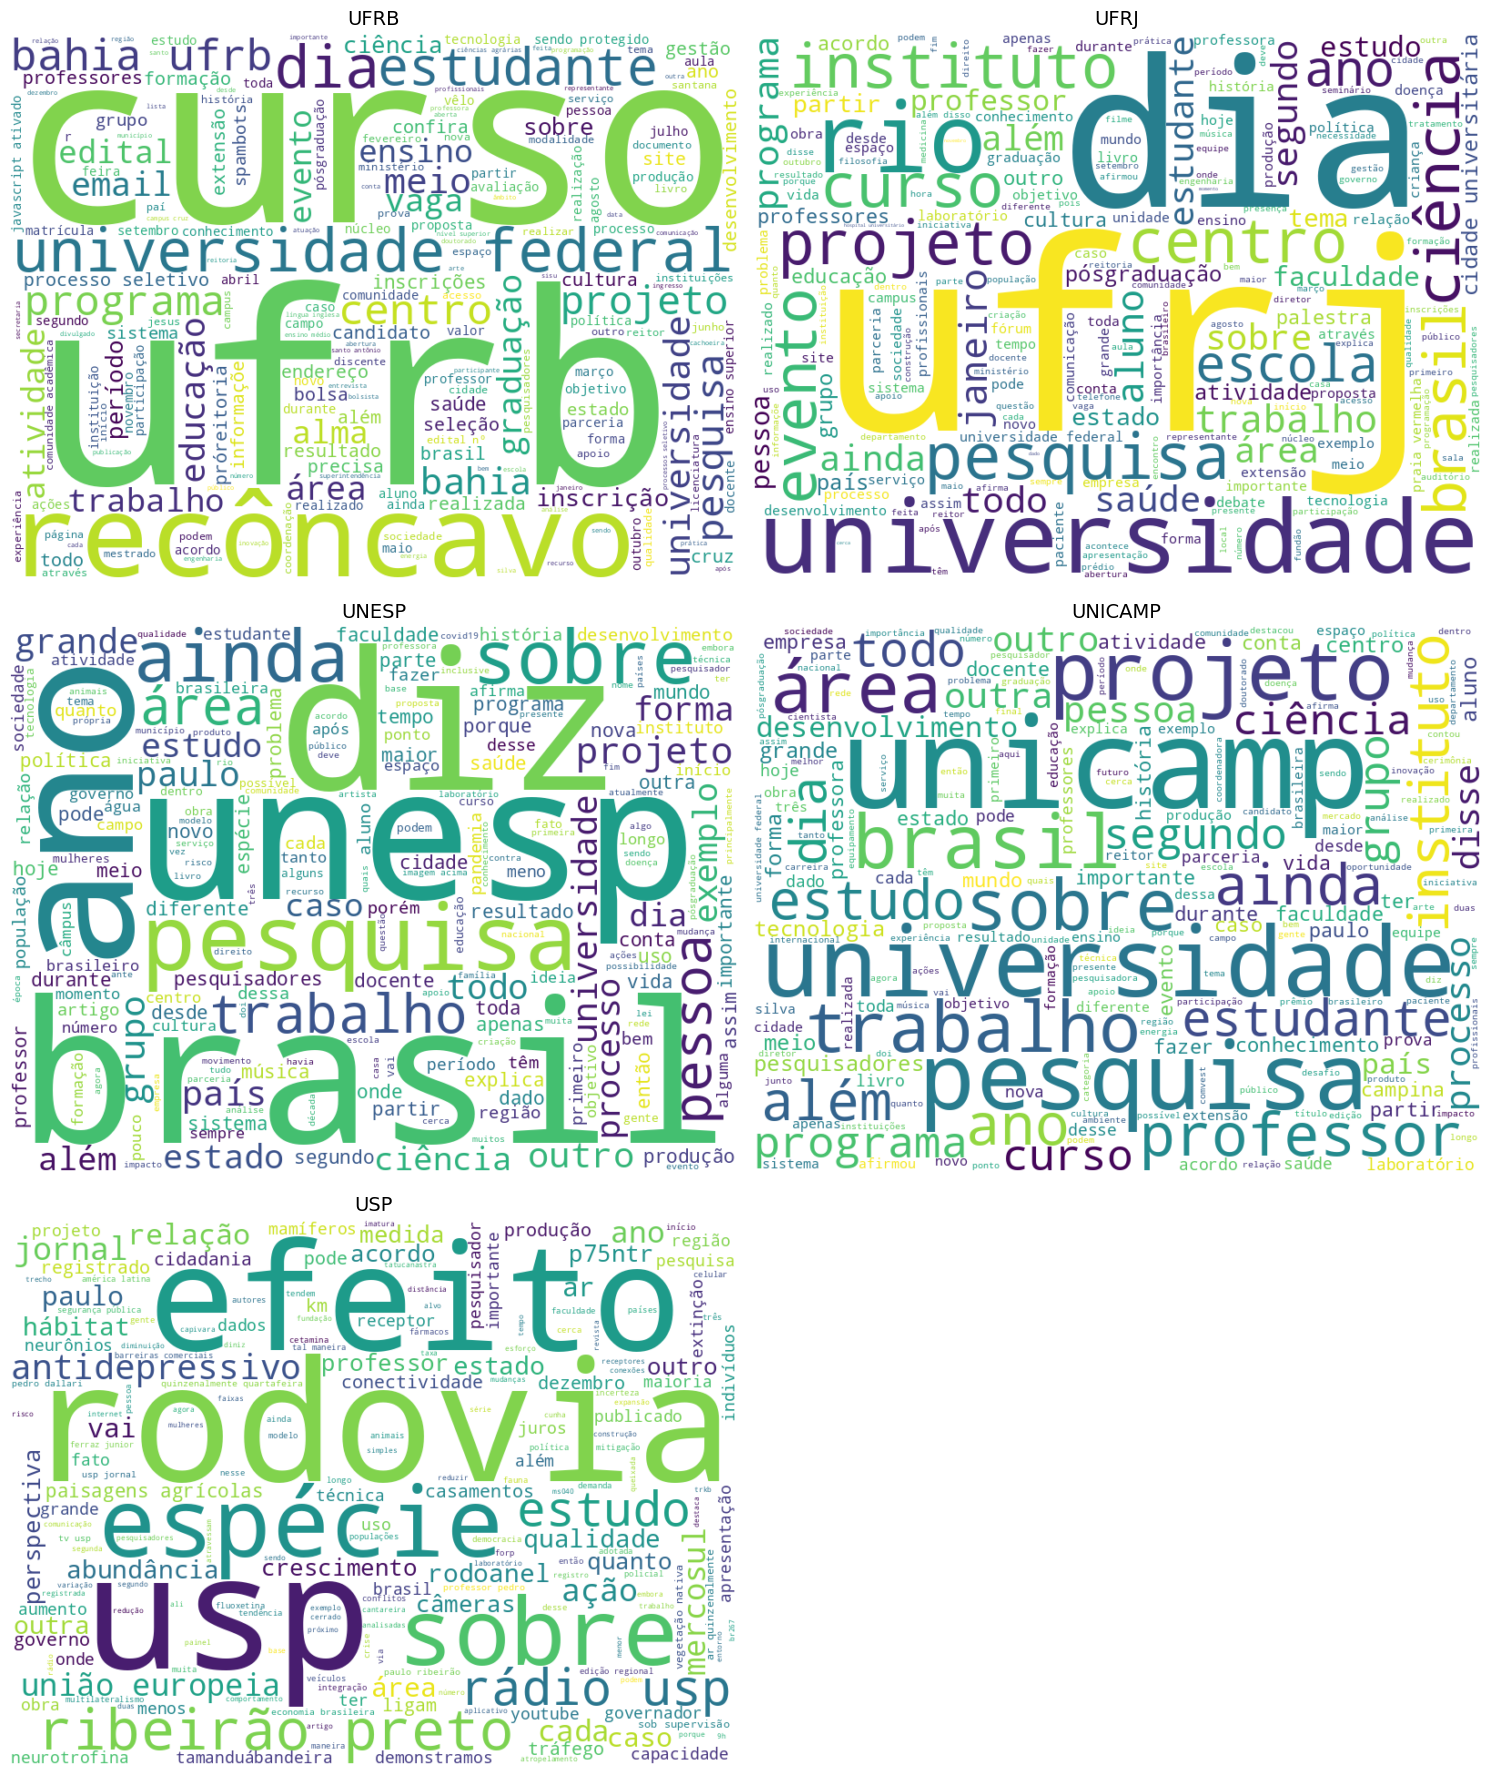

In [ ]:
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import string

stopwords = nltk.corpus.stopwords.words('portuguese')

# Função para carregar e preprocessar textos
def preprocess_texts(dataset_path):
    with open(dataset_path, "r", encoding="utf-8") as file:
        data = json.load(file)
    texts = [item.get("Text", "") for item in data]
    texts = " ".join(texts).lower()  # Concatenar e normalizar para minúsculas
    for punctuation in string.punctuation:
        texts = texts.replace(punctuation, "")  # Remover pontuações
    return texts

# Gerar wordclouds
wordclouds = []
for dataset in datasets:
    texts = preprocess_texts(dataset)
    wordcloud = WordCloud(
        stopwords=stopwords,
        background_color="white",
        width=800,
        height=600
    ).generate(texts)
    wordclouds.append(wordcloud)
    
# Plotar as wordclouds em um layout 3x2
fig, axes = plt.subplots(3, 2, figsize=(15, 18))  # 3 linhas, 2 colunas
axes = axes.flatten()  # Flatten a matriz 3x2 para facilitar o acesso às células

titles = ["UFRB", "UFRJ", "UNESP", "UNICAMP", "USP"]

for i, ax in enumerate(axes[:5]):  # Só utilizar os primeiros 5 e deixar o último em branco
    ax.imshow(wordclouds[i], interpolation="bilinear")
    ax.set_title(titles[i], fontsize=14)
    ax.axis("off")

# Deixar o último gráfico vazio
axes[5].axis("off")

plt.tight_layout()
plt.show()